## Vision Project Walkthrough

In [1]:
%matplotlib inline
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
#imageio.plugins.ffmpeg.download()

## Generating random images from the test data set

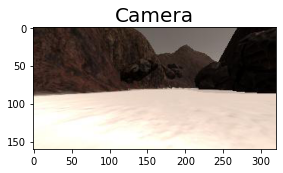

In [2]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
index = np.random.randint(0, len(img_list) - 1)
image = mpimg.imread(img_list[index])

fig = plt.figure(figsize=(20,20))
plt.subplot(141)
plt.title('Camera', fontsize = 20 )
plt.imshow(image)


## getting rocks and grid

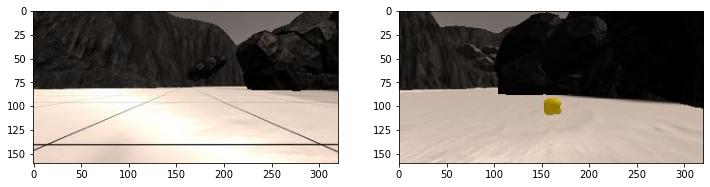

In [3]:
example_grid= "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock1.jpg"
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Warping Image on bird eye view

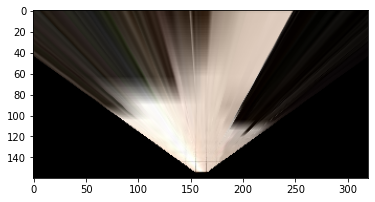

In [4]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding for camera

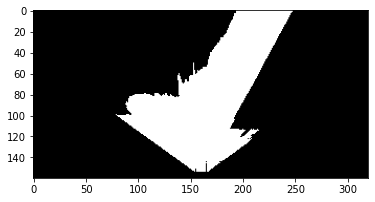

In [5]:
# Identify pixels above the threshold
# Threshold of RGB > 150 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(150, 150, 150)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')

## Color thresholding for obstacles

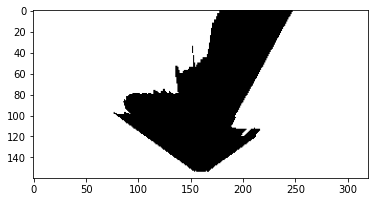

In [6]:
def obstacle_thresh(img, rgb_thresh=(150, 150, 150)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    below_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[below_thresh] = 1
    # Return the binary image
    return color_select

obstacles = obstacle_thresh(warped)
plt.imshow(obstacles,cmap="gray")

## Color thresholding for rock

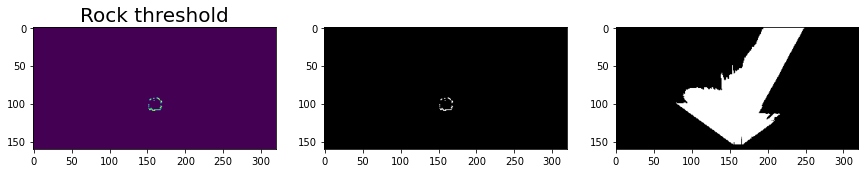

In [10]:
def rock_thresh(img, threshold_low=(99, 99, 19), threshold_high=(210, 210, 55)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:, :, 0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > threshold_low[0]) & (img[:,:,0] < threshold_high[0])  \
                   & (img[:,:,1] > threshold_low[1]) & (img[:,:,1] < threshold_high[1]) \
                   & (img[:,:,2] > threshold_low[2]) & (img[:,:,2] < threshold_high[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    return color_select

rock_thresh = rock_thresh(rock_img)
fig = plt.figure(figsize=(20,20))
plt.subplot(141)
plt.title('Rock threshold', fontsize = 20 )
plt.imshow(rock_thresh)
plt.subplot(142)
plt.imshow(rock_thresh, cmap = "gray")
plt.subplot(143)
threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')

# Adjust to world Coordinates

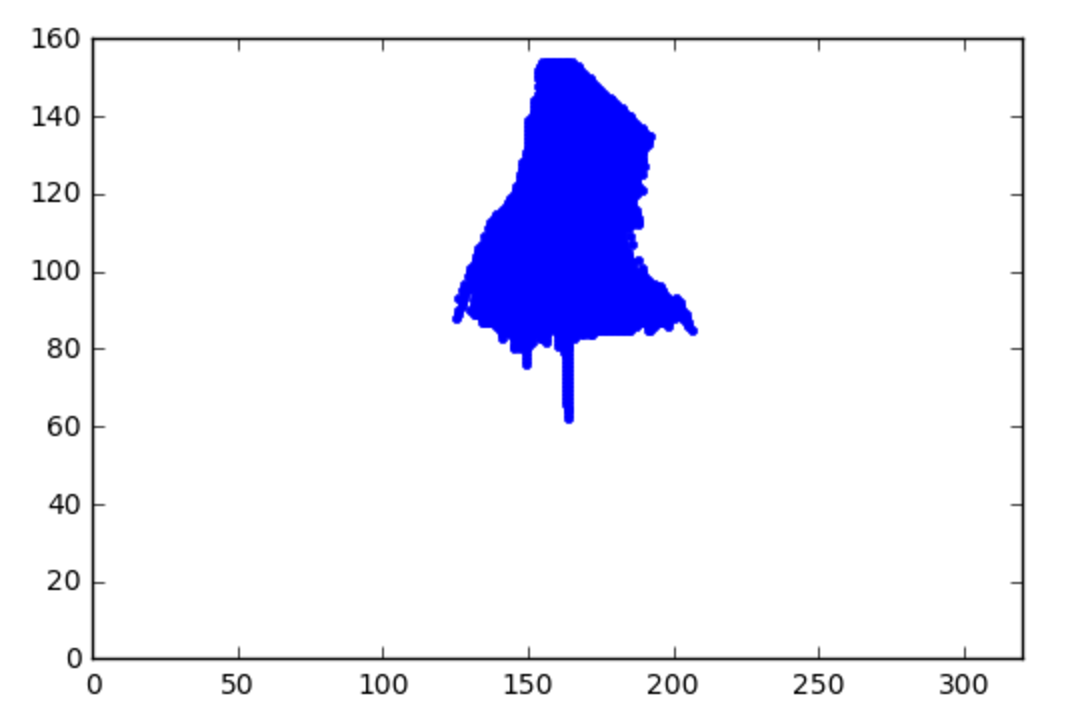

## World Map

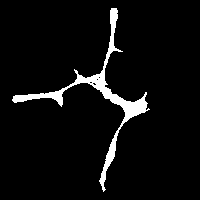

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

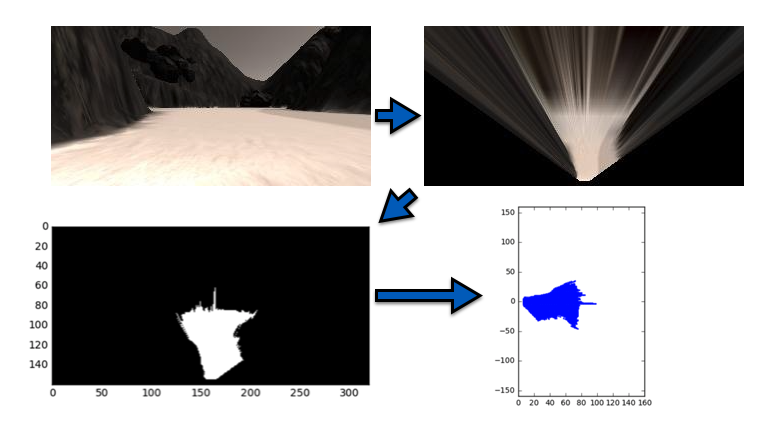

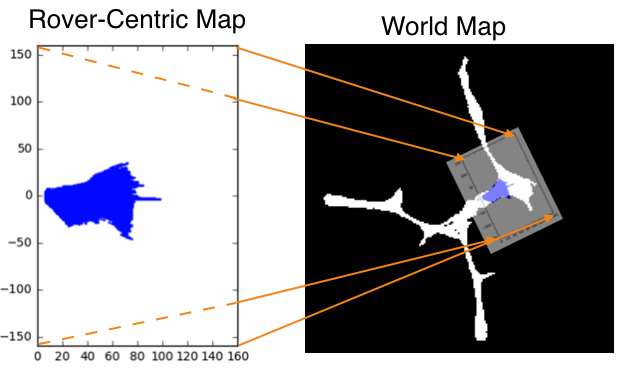

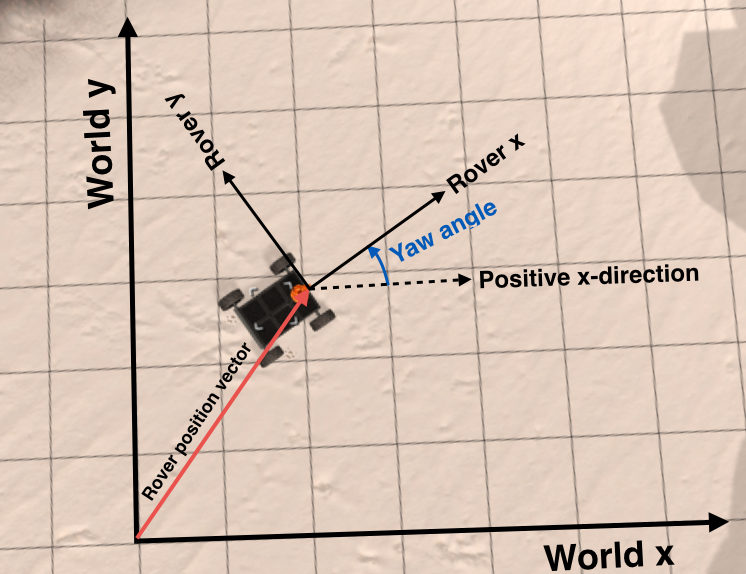

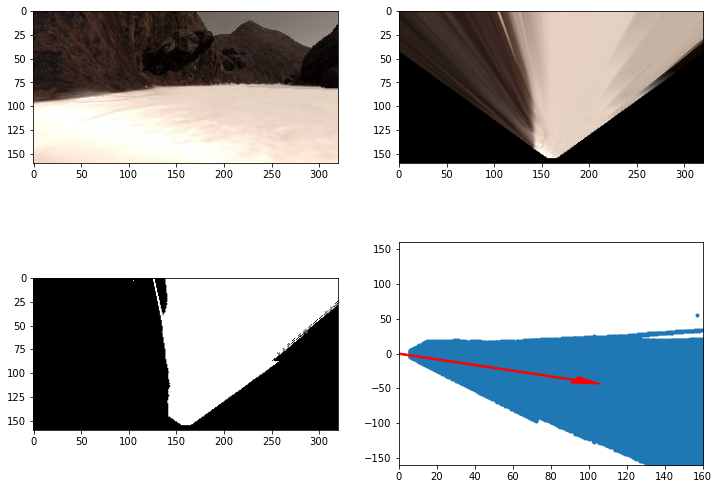

In [15]:

# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float32)
    
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad) - (ypix * np.sin(yaw_rad)))
    ypix_rotated = (xpix * np.sin(yaw_rad) + (ypix * np.cos(yaw_rad)))
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot) + xpos
    ypix_translated = (ypix_rot) + ypos
    # Return the result 
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    #Apply rotation
    xpix_rot , ypix_rot = rotate_pix(xpix,ypix, yaw)
    #apply translation
    xpix_trans, ypix_trans = translate_pix(xpix_rot,ypix_rot,xpos,ypos,scale)
    #do rotation, translation, clipping at the same time
    x_pix_world = np.clip(np.int_(xpix_trans), 0, world_size-1)
    y_pix_world = np.clip(np.int_(ypix_trans), 0, world_size-1)
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

